In [ ]:
pip install stable-baselines3[extra] lightsim2grid grid2op

In [3]:
import gymnasium as gym
from gymnasium import spaces
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward 
from lightsim2grid import LightSimBackend
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import pickle

C:\Users\makha\AppData\Roaming\Python\Python311\site-packages\grid2op\Backend\pandaPowerBackend.py:36: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Program Files\Python311\python.exe -m pip install numba

  warnings.warn(


In [3]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox" 

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward  
        
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        obs_attr_to_keep = [
            "rho",
            "line_status",
            "topo_vect",
            "load_p",
            "load_q",
            "gen_p",
            "gen_v"
        ]

        self.observation_space = spaces.Dict({
            k: self._gym_env.observation_space[k] for k in obs_attr_to_keep
        })

    def setup_actions(self):
        self.action_space = spaces.Dict({
            'line_status': spaces.MultiDiscrete([3] * self._g2op_env.n_line),
            'sub_change': spaces.MultiDiscrete([3] * self._g2op_env.n_sub)
        })

    def reset(self, seed=None, options=None):
        obs, info = self._gym_env.reset(seed=seed)
        return self._process_observation(obs), info

    def step(self, action):
        g2op_action = self._gym_env.action_space.sample()  
        g2op_action['set_line_status'][:len(action['line_status'])] = action['line_status'] - 1  
        g2op_action['set_bus'][:len(action['sub_change'])] = action['sub_change'] - 1  
        
        obs, reward, done, truncated, info = self._gym_env.step(g2op_action)
        return self._process_observation(obs), reward, done, truncated, info


    def _process_observation(self, obs):
        return {k: obs[k] for k in self.observation_space.spaces.keys()}

    def render(self):
        return self._gym_env.render()

    def close(self):
        self._gym_env.close()

In [4]:
class FlattenedActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = spaces.MultiDiscrete([
            *self.env.action_space['line_status'].nvec,
            *self.env.action_space['sub_change'].nvec
        ])

    def action(self, action):
        n_line = len(self.env.action_space['line_status'].nvec)
        action_dict = {
            'line_status': action[:n_line],
            'sub_change': action[n_line:]
        }
        return action_dict

In [5]:
env = Gym2OpEnv()
print("Before Observation Space:")
for i, key in enumerate(env.action_space):
    print(f'{i}. {key}: {env.action_space[key]}')
print("--------------------------------------------->")
print("")
env = FlattenedActionWrapper(env)
print("After Observation Space:", env.action_space)

Before Observation Space:
0. line_status: MultiDiscrete([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3])
1. sub_change: MultiDiscrete([3 3 3 3 3 3 3 3 3 3 3 3 3 3])
--------------------------------------------->

After Observation Space: MultiDiscrete([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3])


In [4]:
class PrintLogCallback(BaseCallback):
    def __init__(self, verbose=1, training=''):
        super(PrintLogCallback, self).__init__(verbose)
        self.rewards = []
        self.mean_rewards = []
        self.entropy_losses = []
        self.explained_variances = []
        self.ep_len_mean = []
        self.policy_gradient_loss = []
        self.value_loss = []
        self.iterations = []
        self.training = training

    def _on_step(self) -> bool:
        if self.n_calls % 100 == 0:  
            reward = self.locals['rewards'][0]
            self.rewards.append(reward)
            self.iterations.append(self.n_calls)
            print(f"Step: {self.n_calls}")
        return True

    def _on_rollout_end(self):
        if len(self.model.ep_info_buffer) > 0:
            mean_reward = np.mean([ep_info["r"] for ep_info in self.model.ep_info_buffer])
            self.mean_rewards.append(mean_reward)
            print(f"Rollout End: Mean Reward Collected: {mean_reward}")
        
        if self.training == "PPO":
            if hasattr(self.model, 'logger'):
                log_data = self.model.logger.name_to_value
                print(f"Log Data: {log_data}")  

                if 'train/explained_variance' in log_data:
                    self.explained_variances.append(log_data['train/explained_variance'])

                if 'train/entropy_loss' in log_data:
                    self.entropy_losses.append(log_data['train/entropy_loss'])

                if 'rollout/ep_len_mean' in log_data:
                    self.ep_len_mean.append(log_data['rollout/ep_len_mean'])

                if 'train/policy_gradient_loss' in log_data:
                    self.policy_gradient_loss.append(log_data['train/policy_gradient_loss'])

                if 'train/value_loss' in log_data:
                    self.value_loss.append(log_data['train/value_loss'])
        
        print(f"Iterations: {self.iterations}, Mean Rewards: {self.mean_rewards}")


In [116]:
def train_ppo(env, total_timesteps=100000):
    model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log="./ppo_tensorboard/")
    callback = PrintLogCallback(training="PPO")
    model.learn(total_timesteps=total_timesteps, callback=callback)
    return model, callback

def evaluate_agent(model, env, n_eval_episodes=10):
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes)
    return mean_reward, std_reward

In [7]:
def plot_training_metrics(callback, title):
    lists_to_check = [
        callback.iterations, 
        callback.mean_rewards, 
        callback.explained_variances, 
        callback.entropy_losses, 
        callback.ep_len_mean, 
        callback.policy_gradient_loss, 
        callback.value_loss
    ]
    
    non_empty_lists = [lst for lst in lists_to_check if len(lst) > 0]
    if len(non_empty_lists) == 0:
        print("No data available to plot.")
        return

    min_length = min(len(lst) for lst in non_empty_lists)
    iterations = callback.iterations[:min_length]
    plt.figure(figsize=(20, 10))  
    
    if callback.mean_rewards:
        plt.subplot(2, 3, 1)
        plt.plot(iterations, callback.mean_rewards[:min_length], marker='o', color='b')
        plt.title(f'Mean Reward Over Iterations for {title}')
        plt.xlabel('Iterations')
        plt.ylabel('Mean Reward')
        plt.grid(True)

    if callback.explained_variances:
        plt.subplot(2, 3, 2)
        plt.plot(iterations, callback.explained_variances[:min_length], marker='o', color='g')
        plt.title(f'Explained Variance Over Iterations for {title}')
        plt.xlabel('Iterations')
        plt.ylabel('Explained Variance')
        plt.grid(True)

    if callback.entropy_losses:
        plt.subplot(2, 3, 3)
        plt.plot(iterations, callback.entropy_losses[:min_length], marker='o', color='r')
        plt.title(f'Entropy Loss Over Iterations for {title}')
        plt.xlabel('Iterations')
        plt.ylabel('Entropy Loss')
        plt.grid(True)

    if callback.ep_len_mean:
        plt.subplot(2, 3, 4)
        plt.plot(iterations, callback.ep_len_mean[:min_length], marker='o', color='purple')
        plt.title(f'Episode Length Mean Over Iterations for {title}')
        plt.xlabel('Iterations')
        plt.ylabel('Episode Length Mean')
        plt.grid(True)

    if callback.policy_gradient_loss:
        plt.subplot(2, 3, 5)
        plt.plot(iterations, callback.policy_gradient_loss[:min_length], marker='o', color='orange')
        plt.title(f'Policy Gradient Loss Over Iterations for {title}')
        plt.xlabel('Iterations')
        plt.ylabel('Policy Gradient Loss')
        plt.grid(True)

    if callback.value_loss:
        plt.subplot(2, 3, 6)
        plt.plot(iterations, callback.value_loss[:min_length], marker='o', color='cyan')
        plt.title(f'Value Loss Over Iterations for {title}')
        plt.xlabel('Iterations')
        plt.ylabel('Value Loss')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(title + '.png')
    plt.show()


In [117]:
ppo_model_1, ppo_callback_1 = train_ppo(env, total_timesteps=300000)
callback_data = {
    'iterations': ppo_callback_1.iterations,
    'mean_rewards': ppo_callback_1.mean_rewards,
    'explained_variances': ppo_callback_1.explained_variances,
    'entropy_losses': ppo_callback_1.entropy_losses,
    'ep_len_mean': ppo_callback_1.ep_len_mean,
    'policy_gradient_loss': ppo_callback_1.policy_gradient_loss,
    'value_loss': ppo_callback_1.value_loss
}

with open('ppo_callback_data_1.pkl', 'wb') as f:
    pickle.dump(callback_data, f)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tensorboard/PPO_4
Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Step: 1100
Step: 1200
Step: 1300
Step: 1400
Step: 1500
Step: 1600
Step: 1700
Step: 1800
Step: 1900
Step: 2000
Rollout End: Mean Reward Collected: 265.685481
Log Data: defaultdict(<class 'float'>, {})
Iterations: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], Mean Rewards: [265.685481]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 807      |
|    ep_rew_mean     | 266      |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 72       |
|    total_timesteps | 2048     |
---------------------------------
Step: 2100
Step: 2200
Step: 2300
Step: 2400
Step: 2500
Step: 2600
Step: 2700


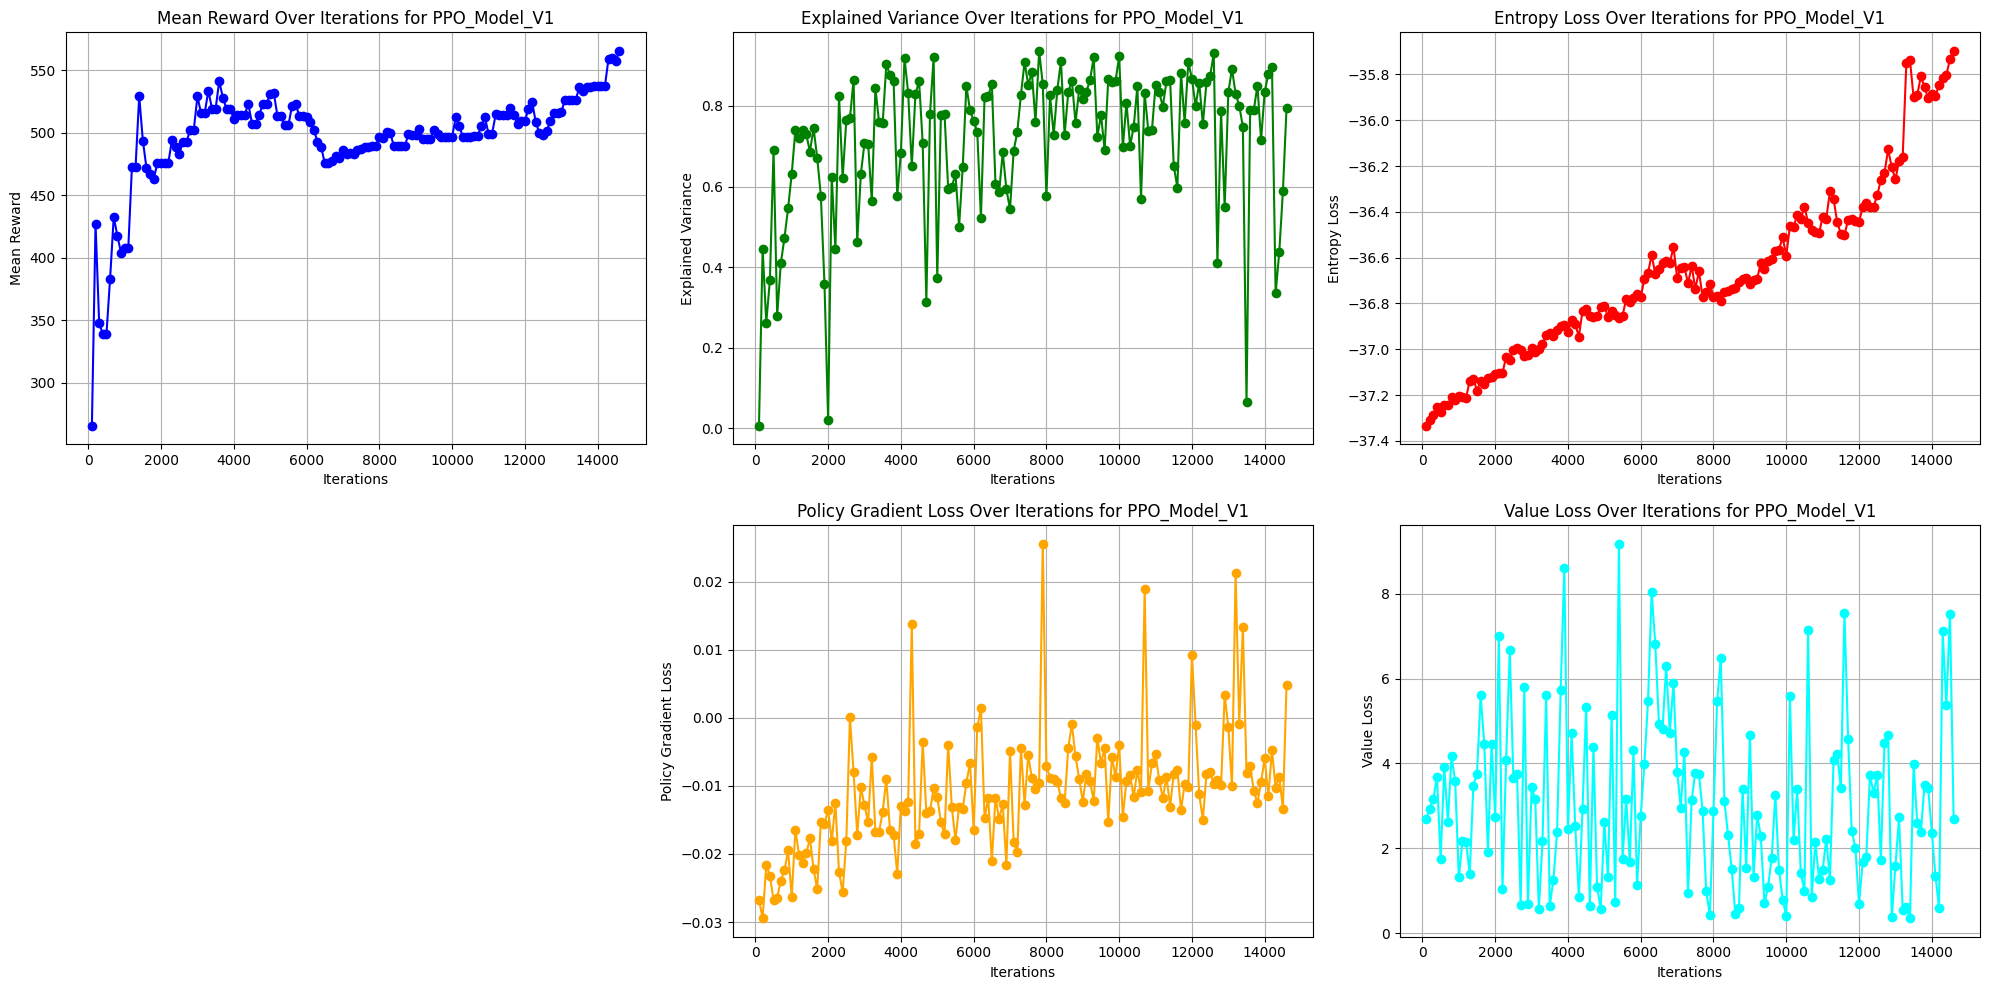

In [118]:
plot_training_metrics(ppo_callback_1, "PPO_Model_V1")

In [ ]:
ppo_mean_reward, ppo_std_reward = evaluate_agent(ppo_model_1, env)
print(f"PPO Mean Reward: {ppo_mean_reward}, Std: {ppo_std_reward}")

In [10]:
ppo_model_1.save("PPO_MODEL_V1")

In [ ]:
#************************************************************************************
# MODEL V2
#************************************************************************************

In [20]:
class Gym2OpEnv(gym.Env):
    def __init__(self, max_level=3):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"
        self.current_level = 1
        self.max_level = max_level

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p
        )

        self._gym_env = gym_compat.GymEnv(self._g2op_env)
        self.setup_observations()
        self.setup_actions()

    def increase_level(self):
        if self.current_level < self.max_level:
            self.current_level += 1
        self.setup_actions()
        print(f'bool {self.current_level < self.max_level}, current level {self.current_level}, action space {self.action_space}')

    def setup_observations(self):
        if self.current_level == 1:
            obs_attr_to_keep = ['line_status', 'gen_p', 'load_p']
        elif self.current_level == 2:
            obs_attr_to_keep = ['rho', 'topo_vect', 'line_status', 'load_p', 'gen_p']
        else:
            obs_attr_to_keep = ['rho', 'line_status', 'topo_vect', 'load_p', 'load_q', 'gen_p', 'gen_v']

        self.observation_space = spaces.Dict({
            k: self._gym_env.observation_space[k] for k in obs_attr_to_keep
        })

    def setup_actions(self):
        if self.current_level == 1:
            self.action_space = spaces.Dict({
                'line_status': spaces.MultiDiscrete([3] * self._g2op_env.n_line),
                'sub_change': spaces.MultiDiscrete([3] * self._g2op_env.n_sub)
            })
        elif self.current_level == 2:
            self.action_space = spaces.Discrete(self._g2op_env.n_sub)
        else:
            self.action_space = spaces.Discrete(2)

    def reset(self, seed=None, options=None):
        obs, info = self._gym_env.reset(seed=seed)
        return self._process_observation(obs), info

    def step(self, action):
        g2op_action = self._gym_env.action_space.sample()

        if self.current_level == 1:
            g2op_action['set_line_status'][:len(action['line_status'])] = action['line_status'] - 1
            g2op_action['set_bus'][:len(action['sub_change'])] = action['sub_change'] - 1

        elif self.current_level == 2:
            selected_substation = action  
            g2op_action['set_bus'][selected_substation] = 1  

        elif self.current_level == 3:
            if isinstance(action, np.ndarray):
                if action.size == 1:
                    action_value = action.item()  
                else:
                    action_value = action[0]  
            else:
                action_value = action  

            if action_value == 0:
                pass
            elif action_value == 1:
                overloaded_lines = np.where(self._g2op_env.get_obs().rho > 1.0)[0]
                if len(overloaded_lines) > 0:
                    g2op_action['set_line_status'][overloaded_lines[0]] = 0 

        obs, reward, done, truncated, info = self._gym_env.step(g2op_action)
        return self._process_observation(obs), reward, done, truncated, info

    def _process_observation(self, obs):
        return {k: obs[k] for k in self.observation_space.spaces.keys()}

    def render(self):
        return self._gym_env.render()

    def close(self):
        self._gym_env.close()

In [21]:
class FlattenedActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        if isinstance(self.env.action_space, spaces.Dict):
            self.action_space = spaces.MultiDiscrete([
                *self.env.action_space['line_status'].nvec,
                *self.env.action_space['sub_change'].nvec
            ])
        else:
            self.action_space = self.env.action_space

    def action(self, action):
        if isinstance(self.env.action_space, spaces.Dict):
            n_line = len(self.env.action_space['line_status'].nvec)
            action_dict = {
                'line_status': action[:n_line],
                'sub_change': action[n_line:]
            }
            return action_dict
        else:
            return action

In [101]:
def train_ppo2(env, total_timesteps=100000, initial_level=0):
    env.current_level = initial_level
    env = FlattenedActionWrapper(env)   
    model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=f"./ppo_tensorboard_level_{initial_level}/")
    callback = PrintLogCallback(training="PPO")
    
    for level in range(initial_level, env.max_level):
        print(f'Iteration: {level}')
        if isinstance(env, FlattenedActionWrapper):
            env = env.env  
            
        env.increase_level()
        env = FlattenedActionWrapper(env)
        model.learn(total_timesteps=total_timesteps // env.max_level, callback=callback)

    return model, callback


In [106]:
env = Gym2OpEnv(max_level=3)  
ppo_model_v2, ppo_callback_v2 = train_ppo2(env, total_timesteps=300000)
callback_data2 = {
    'iterations': ppo_callback_v2.iterations,
    'mean_rewards': ppo_callback_v2.mean_rewards,
    'explained_variances': ppo_callback_v2.explained_variances,
    'entropy_losses': ppo_callback_v2.entropy_losses,
    'ep_len_mean': ppo_callback_v2.ep_len_mean,
    'policy_gradient_loss': ppo_callback_v2.policy_gradient_loss,
    'value_loss': ppo_callback_v2.value_loss
}

with open('ppo_callback_data_v2.pkl', 'wb') as f:
    pickle.dump(callback_data2, f)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Iteration: 0
bool True, current level 1, action space Dict('line_status': MultiDiscrete([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]), 'sub_change': MultiDiscrete([3 3 3 3 3 3 3 3 3 3 3 3 3 3]))
Logging to ./ppo_tensorboard_level_0/PPO_43


C:\Users\makha\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.max_level to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_level` for environment variables or `env.get_wrapper_attr('max_level')` that will search the reminding wrappers.
  logger.warn(


Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Step: 1100
Step: 1200
Step: 1300
Step: 1400
Step: 1500
Step: 1600
Step: 1700
Step: 1800
Step: 1900
Step: 2000
Rollout End: Mean Reward Collected: 403.5
Log Data: defaultdict(<class 'float'>, {})
Iterations: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], Mean Rewards: [403.5]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 807      |
|    ep_rew_mean     | 404      |
| time/              |          |
|    fps             | 24       |
|    iterations      | 1        |
|    time_elapsed    | 83       |
|    total_timesteps | 2048     |
---------------------------------
Step: 2100
Step: 2200
Step: 2300
Step: 2400
Step: 2500
Step: 2600
Step: 2700
Step: 2800
Step: 2900
Step: 3000
Step: 3100
Step: 3200
Step: 3300
Step: 3400
Step: 3500
Step: 3600
Step: 3700
Step: 3800
Step: 3900
Step: 40

C:\Users\makha\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.max_level to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_level` for environment variables or `env.get_wrapper_attr('max_level')` that will search the reminding wrappers.
  logger.warn(


Logging to ./ppo_tensorboard_level_0/PPO_44
Step: 100400
Step: 100500
Step: 100600
Step: 100700
Step: 100800
Step: 100900
Step: 101000
Step: 101100
Step: 101200
Step: 101300
Step: 101400
Step: 101500
Step: 101600
Step: 101700
Step: 101800
Step: 101900
Step: 102000
Step: 102100
Step: 102200
Step: 102300
Step: 102400
Log Data: defaultdict(<class 'float'>, {})
Iterations: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 

C:\Users\makha\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.max_level to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_level` for environment variables or `env.get_wrapper_attr('max_level')` that will search the reminding wrappers.
  logger.warn(


Logging to ./ppo_tensorboard_level_0/PPO_45
Step: 200800
Step: 200900
Step: 201000
Step: 201100
Step: 201200
Step: 201300
Step: 201400
Step: 201500
Step: 201600
Step: 201700
Step: 201800
Step: 201900
Step: 202000
Step: 202100
Step: 202200
Step: 202300
Step: 202400
Step: 202500
Step: 202600
Step: 202700
Rollout End: Mean Reward Collected: 550.0
Log Data: defaultdict(<class 'float'>, {})
Iterations: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100,

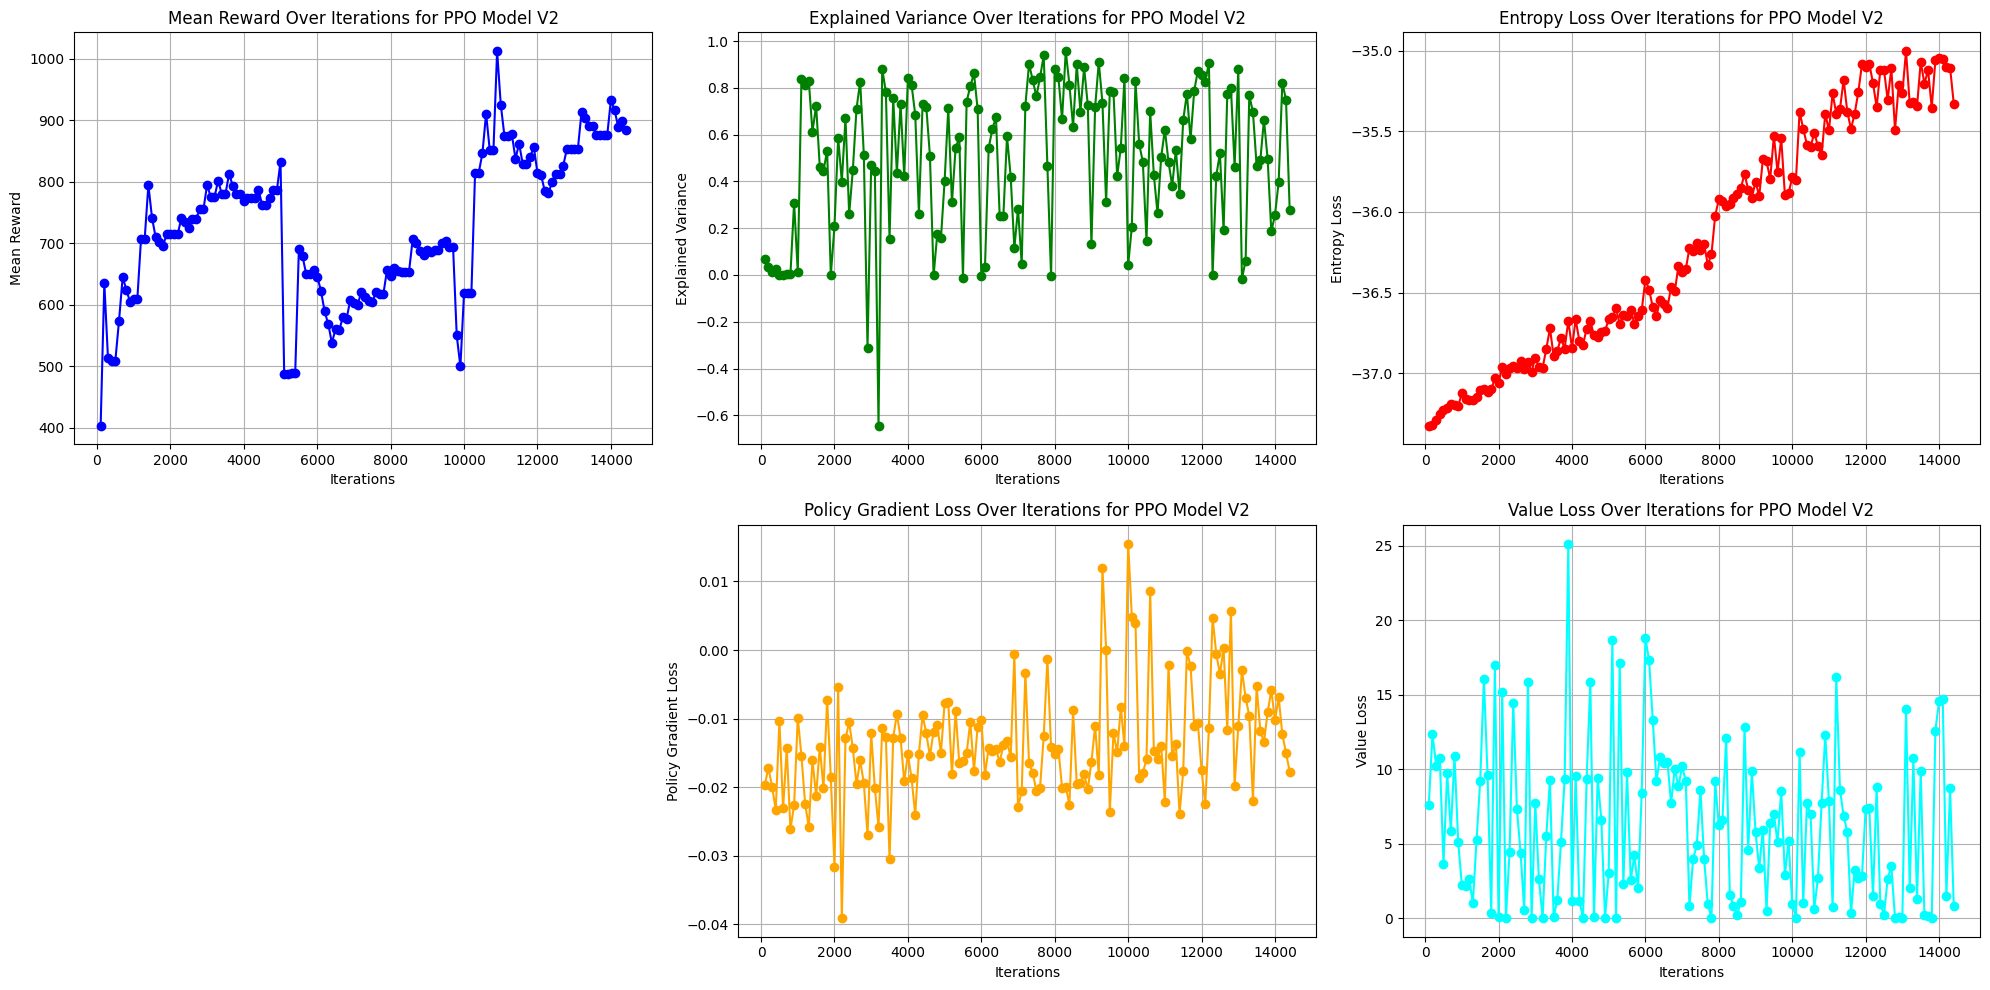

In [107]:
plot_training_metrics(ppo_callback_v2, "PPO Model V2")

In [108]:
ppo_model_v2.save("PPO_MODEL_V2")

In [ ]:
#************************************************************************************
# MODEL V3
#************************************************************************************

In [109]:
class Gym2OpEnv(gym.Env):
    def __init__(self, max_level=1):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox" 
        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward 

        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        cr = self._g2op_env.get_reward_instance()
        cr.initialize(self._g2op_env)
        self._gym_env = gym_compat.GymEnv(self._g2op_env)
        self.max_level = max_level  
        self.current_level = 0  
        self.rho_threshold = 1  
        self.current_reward = 0
        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        obs_attr_to_keep = [
            "rho",
            "line_status",
            "topo_vect",
            "load_p",
            "load_q",
            "gen_p",
            "gen_v"
        ]

        self.observation_space = spaces.Dict({
            k: self._gym_env.observation_space[k] for k in obs_attr_to_keep
        })

    def setup_actions(self):
        self.action_space = spaces.Dict({
            'line_status': spaces.MultiDiscrete([3] * self._g2op_env.n_line),
            'sub_change': spaces.MultiDiscrete([3] * self._g2op_env.n_sub)
        })

    def reset(self, seed=None, options=None):
        obs, info = self._gym_env.reset(seed=seed)
        return self._process_observation(obs), info

    def step(self, action):
        best_action = action  
        best_obs = None  
        best_mean_rho = float('inf')  

        for _ in range(5):  
            formatted_action = self._format_action(best_action)
            obs, reward, done, truncated, info = self._gym_env.step(formatted_action)

            mean_rho = np.mean(obs['rho'])  
            if mean_rho > best_mean_rho:
                best_mean_rho = mean_rho  
                best_obs = obs  
                best_action = formatted_action  
                
            if mean_rho <= self.rho_threshold:
                break  

            best_action = self.action_space.sample()

        if best_obs is None:
            best_obs = obs  
            
        return self._process_observation(best_obs), reward, done, truncated, info

    def increase_level(self):
        self.current_level += 1
        if self.current_level < self.max_level:
            self.rho_threshold *= 1  
        print(f"New rho threshold for level {self.current_level}: {self.rho_threshold}")


    def _format_action(self, action):
        g2op_action = self._gym_env.action_space.sample() 
        g2op_action['set_line_status'][:len(action['line_status'])] = action['line_status'] - 1
        g2op_action['set_bus'][:len(action['sub_change'])] = action['sub_change'] - 1
        return g2op_action

    def _process_observation(self, obs):
        return {k: obs[k] for k in self.observation_space.spaces.keys()}

    def render(self):
        return self._gym_env.render()

    def close(self):
        self._gym_env.close()

In [110]:
def train_ppo3(env, total_timesteps=100000, initial_level=0):
    env.current_level = initial_level
    env = FlattenedActionWrapper(env)   
    model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=f"./ppo_tensorboard_level_{initial_level}/")
    callback = PrintLogCallback(training="PPO")
    
    for level in range(initial_level, env.max_level):
        print(f'Iteration: {level}')
        if isinstance(env, FlattenedActionWrapper):
            env = env.env  
            
        env = FlattenedActionWrapper(env)
        model.learn(total_timesteps=total_timesteps // env.max_level, callback=callback)

    return model, callback

In [111]:
env = Gym2OpEnv()
ppo_model_v3, ppo_callback_v3 = train_ppo3(env, 300000)
callback_data3 = {
    'iterations': ppo_callback_v3.iterations,
    'mean_rewards': ppo_callback_v3.mean_rewards,
    'explained_variances': ppo_callback_v3.explained_variances,
    'entropy_losses': ppo_callback_v3.entropy_losses,
    'ep_len_mean': ppo_callback_v3.ep_len_mean,
    'policy_gradient_loss': ppo_callback_v3.policy_gradient_loss,
    'value_loss': ppo_callback_v3.value_loss
}

with open('ppo_callback_data_v3.pkl', 'wb') as f:
    pickle.dump(callback_data3, f)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Iteration: 0


C:\Users\makha\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.max_level to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_level` for environment variables or `env.get_wrapper_attr('max_level')` that will search the reminding wrappers.
  logger.warn(


Logging to ./ppo_tensorboard_level_0/PPO_46
Step: 100
Step: 200
Step: 300
Step: 400
Step: 500
Step: 600
Step: 700
Step: 800
Step: 900
Step: 1000
Step: 1100
Step: 1200
Step: 1300
Step: 1400
Step: 1500
Step: 1600
Step: 1700
Step: 1800
Step: 1900
Step: 2000
Rollout End: Mean Reward Collected: 403.5
Log Data: defaultdict(<class 'float'>, {})
Iterations: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], Mean Rewards: [403.5]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 807      |
|    ep_rew_mean     | 404      |
| time/              |          |
|    fps             | 27       |
|    iterations      | 1        |
|    time_elapsed    | 75       |
|    total_timesteps | 2048     |
---------------------------------
Step: 2100
Step: 2200
Step: 2300
Step: 2400
Step: 2500
Step: 2600
Step: 2700
Step: 2800
Step: 2900
Step: 3000
Step: 3100
Step: 3200
Step: 3300
Step: 3400
Step: 3500
Step: 36

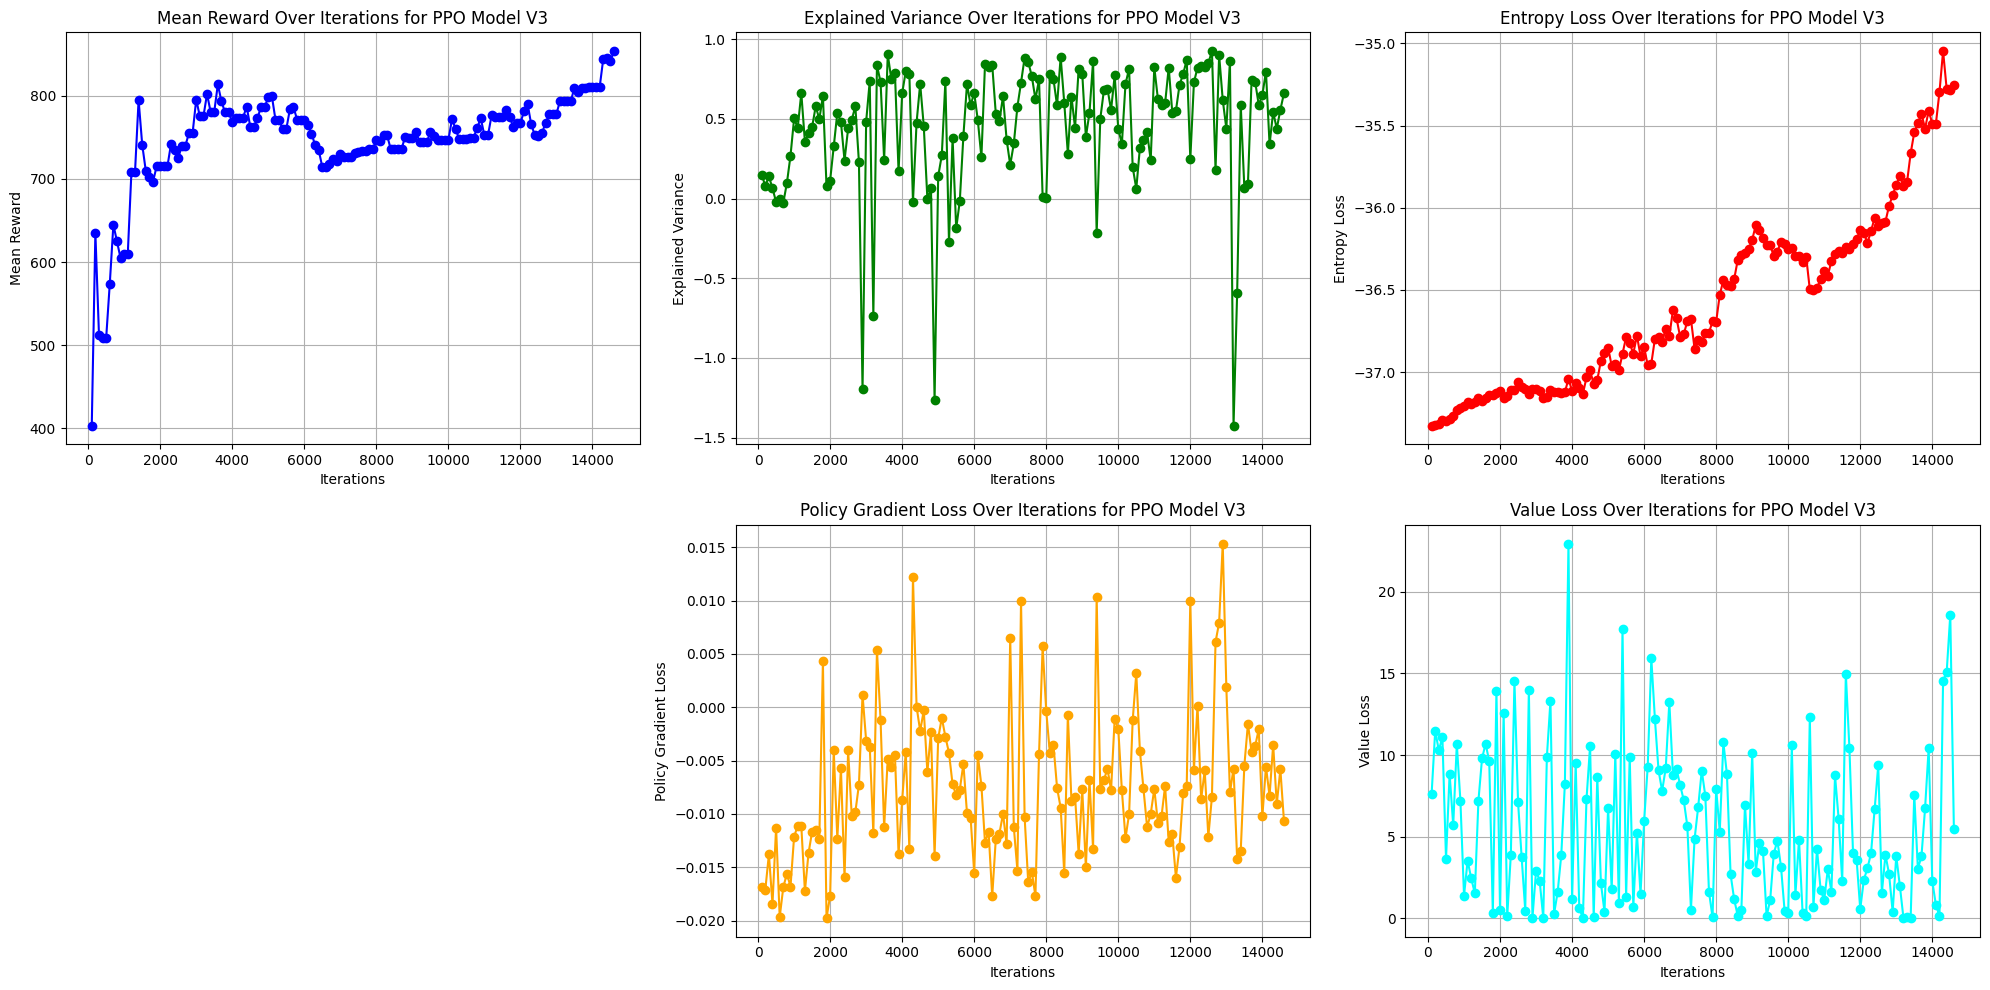

In [112]:
plot_training_metrics(ppo_callback_v3, "PPO Model V3")

In [59]:
ppo_model_v3.save("PPO_MODEL_V3")

In [5]:
# Load the saved data******************************************************************
import pickle
with open('ppo_callback_data_1.pkl', 'rb') as f:
    callback_data = pickle.load(f)

ppo_callback_Loaded_1 = PrintLogCallback(training="PPO")

ppo_callback_Loaded_1.iterations = callback_data['iterations']
ppo_callback_Loaded_1.mean_rewards = callback_data['mean_rewards']
ppo_callback_Loaded_1.explained_variances = callback_data['explained_variances']
ppo_callback_Loaded_1.entropy_losses = callback_data['entropy_losses']
ppo_callback_Loaded_1.ep_len_mean = callback_data['ep_len_mean']
ppo_callback_Loaded_1.policy_gradient_loss = callback_data['policy_gradient_loss']
ppo_callback_Loaded_1.value_loss = callback_data['value_loss']
#****************************************************************************************

with open('ppo_callback_data_v2.pkl', 'rb') as f:
    callback_data_2 = pickle.load(f)

ppo_callback_loaded_2 = PrintLogCallback(training="PPO")

ppo_callback_loaded_2.iterations = callback_data_2['iterations']
ppo_callback_loaded_2.mean_rewards = callback_data_2['mean_rewards']
ppo_callback_loaded_2.explained_variances = callback_data_2['explained_variances']
ppo_callback_loaded_2.entropy_losses = callback_data_2['entropy_losses']
ppo_callback_loaded_2.ep_len_mean = callback_data_2['ep_len_mean']
ppo_callback_loaded_2.policy_gradient_loss = callback_data_2['policy_gradient_loss']
ppo_callback_loaded_2.value_loss = callback_data_2['value_loss']
#*****************************************************************************************

with open('ppo_callback_data_v3.pkl', 'rb') as f:
    callback_data_3 = pickle.load(f)

ppo_callback_loaded_3 = PrintLogCallback(training="PPO")

ppo_callback_loaded_3.iterations = callback_data_3['iterations']
ppo_callback_loaded_3.mean_rewards = callback_data_3['mean_rewards']
ppo_callback_loaded_3.explained_variances = callback_data_3['explained_variances']
ppo_callback_loaded_3.entropy_losses = callback_data_3['entropy_losses']
ppo_callback_loaded_3.ep_len_mean = callback_data_3['ep_len_mean']
ppo_callback_loaded_3.policy_gradient_loss = callback_data_3['policy_gradient_loss']
ppo_callback_loaded_3.value_loss = callback_data_3['value_loss']


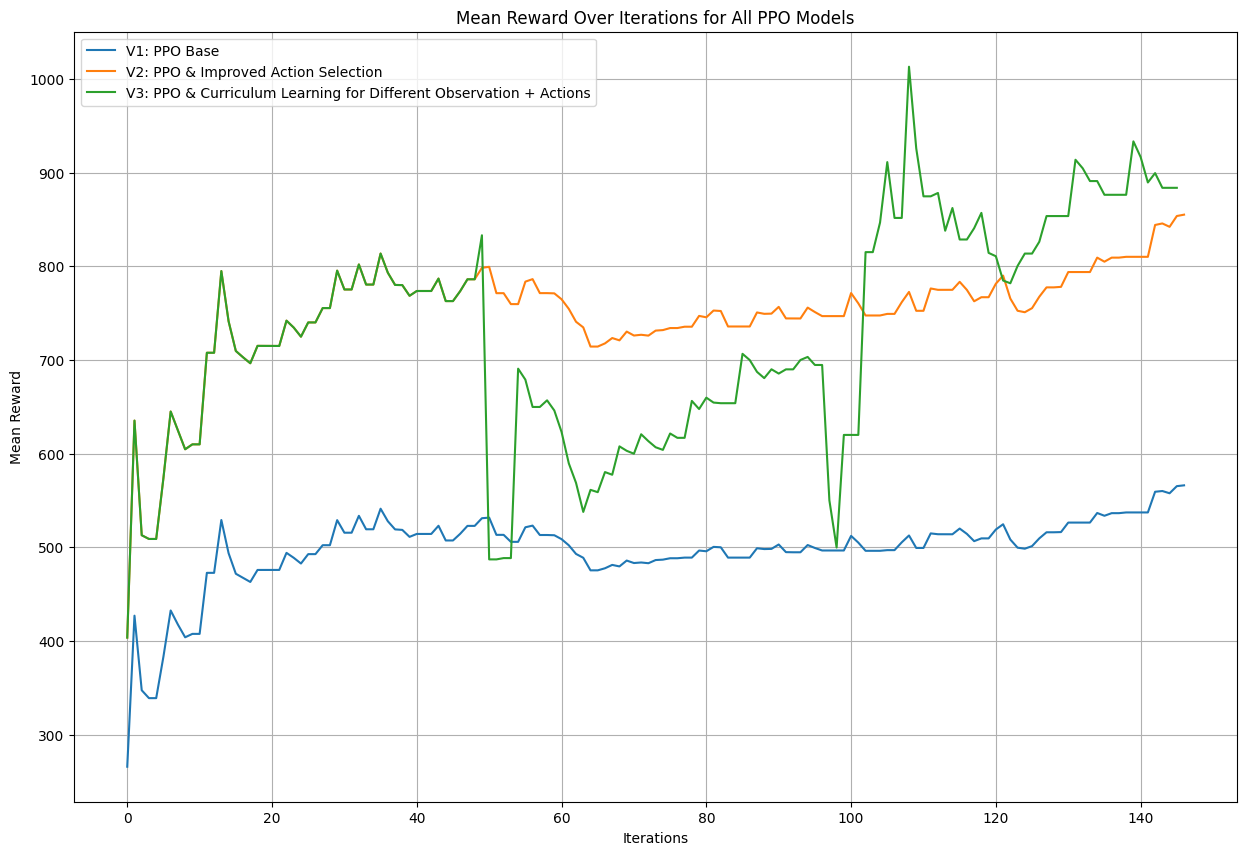

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(ppo_callback_Loaded_1.mean_rewards, label=f'V1: PPO Base')
plt.plot(ppo_callback_loaded_2.mean_rewards, label=f'V2: PPO & Improved Action Selection')
plt.plot(ppo_callback_loaded_3.mean_rewards, label=f'V3: PPO & Curriculum Learning for Different Observation + Actions')
plt.title(f'Mean Reward Over Iterations for All PPO Models')
plt.xlabel('Iterations')
plt.ylabel('Mean Reward')
plt.legend()
plt.grid(True)
plt.savefig('ppo_training_model_comparison.png')